In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import keras
from keras.layers import TextVectorization
from keras.utils import to_categorical

In [3]:
#sotpwords removal
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [14]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
claims_df = pd.read_csv('./data/postprocessed/claims.csv')
claims_df = claims_df.drop(index=1948)
claims_str = np.array(claims_df['claim'])

In [3]:
len(claims_df)

3067

In [4]:
answers_df = pd.read_csv('./data/postprocessed/answers.csv')
answers_str = np.array(answers_df['answer'])

In [5]:
claims_lbl = np.array(claims_df['label'])

In [6]:
len(claims_lbl)

3067

In [7]:
answers_lbl = np.full(len(answers_str), 'Supported')

In [8]:
np.unique(claims_lbl, return_counts=True)

(array(['Conflicting Evidence/Cherrypicking', 'Not Enough Evidence',
        'Refuted', 'Supported'], dtype=object),
 array([ 195,  282, 1742,  848]))

In [11]:
X = np.concatenate([claims_str,answers_str])
y = np.concatenate([claims_lbl,answers_lbl])

In [12]:
del claims_str, answers_str, claims_lbl, answers_lbl

In [13]:
X = [claim.replace('\n', '') for claim in X]

In [15]:
# we have to remove the possessives since we noticed they appeared frequently in the claims
def remove_stopwords_and_possessive(tokens):
    stop_words = set(stopwords.words('english'))
    processed_tokens = []

    for token in tokens:
        # Remove trailing "'s"
        token = re.sub(r"'s\b", '', token)

        if token.lower() not in stop_words:
            processed_tokens.append(token)

    return processed_tokens

In [17]:
processed_sentences = []

for sentence in X:

    word_tokens = word_tokenize(sentence)
    word_tokens = [word.lower() for word in word_tokens if word.isalnum()]
    processed_tokens = remove_stopwords_and_possessive(word_tokens)

    processed_sentence = ' '.join(processed_tokens)
    processed_sentences.append(processed_sentence)

In [20]:
X = processed_sentences.copy()

In [23]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
y_encoded = label_encoder.fit_transform(y)

# Convert integer labels to one-hot encoded format
y_ohe = to_categorical(y_encoded)

In [30]:
y_ohe.shape

(11546, 4)

In [31]:
temp_x, test_x, temp_y, test_y = train_test_split(X, y_ohe, test_size=0.2, shuffle=True, stratify=y_ohe)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.1, stratify=temp_y)

In [32]:
train_tf = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_tf = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

In [33]:
train_dataset = train_tf.shuffle(buffer_size=10000).batch(batch_size=64).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_tf.batch(batch_size=64).prefetch(tf.data.AUTOTUNE)

In [34]:
vectorizer = TextVectorization(max_tokens=1000)
train_text = train_dataset.map(lambda text, label: text)
vectorizer.adapt(train_text)

In [37]:
model = keras.Sequential([
    vectorizer,
    keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=64, mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4)
])
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=keras.optimizers.legacy.Adam(1e-4))

In [38]:
model.fit(train_dataset, epochs=10, validation_data=valid_dataset, validation_steps=20)

Epoch 1/10
130/130 [==============================] - ETA: 0s - loss: 1.1313 - accuracy: 0.7840

130/130 [==============================] - 64s 426ms/step - loss: 1.1313 - accuracy: 0.7840 - val_loss: 0.7840 - val_accuracy: 0.8074
Epoch 2/10
130/130 [==============================] - 49s 371ms/step - loss: 0.7417 - accuracy: 0.8079
Epoch 3/10
130/130 [==============================] - 51s 386ms/step - loss: 0.6842 - accuracy: 0.8079
Epoch 4/10
130/130 [==============================] - 47s 359ms/step - loss: 0.6415 - accuracy: 0.8079
Epoch 5/10
130/130 [==============================] - 51s 395ms/step - loss: 0.5974 - accuracy: 0.8079
Epoch 6/10
130/130 [==============================] - 50s 382ms/step - loss: 0.5554 - accuracy: 0.8083
Epoch 7/10
130/130 [==============================] - 52s 404ms/step - loss: 0.5246 - accuracy: 0.8136
Epoch 8/10
130/130 [==============================] - 45s 342ms/step - loss: 0.5019 - accuracy: 0.8219
Epoch 9/10
130/130 [==============================] - 48s 364ms/step - loss: 0.4843 - accuracy: 0.8257
Epoch 10/10
130/130 [=====================

In [51]:
predictions_ohe = model.predict(valid_x)
pred_y = np.argmax(predictions_ohe, axis=1)
predictions_lbl = label_encoder.inverse_transform(pred_y)
np.unique(predictions_lbl, return_counts=True)

29/29 [==============================] - 1s 30ms/step


(array(['Refuted', 'Supported'], dtype=object), array([ 81, 843]))

In [53]:
valid_y = np.argmax(valid_y, axis=1)
valid_y.shape

(924,)

In [54]:
print('accuracy: '+ str(accuracy_score(pred_y, valid_y)))

accuracy: 0.8138528138528138


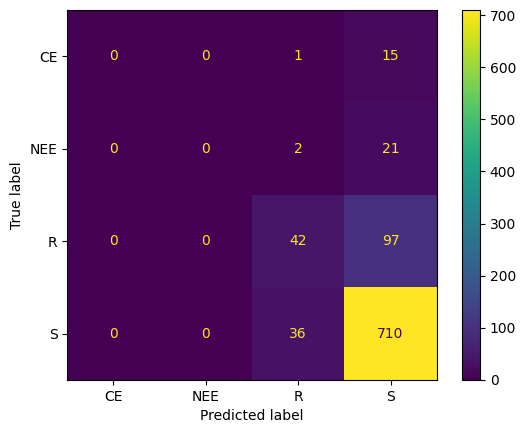

In [58]:
cmd = ConfusionMatrixDisplay(confusion_matrix(valid_y, pred_y), display_labels=['CE', 'NEE', 'R', 'S'])
cmd.plot()